In [1]:
import tensorflow as tf
import utils as u
import h5py
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
import numpy as np
import random as rn


from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import metrics

%matplotlib inline
import itertools

import keras 
from keras.models import load_model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D,Activation,BatchNormalization,LeakyReLU
from keras.utils import to_categorical,plot_model
from keras.models import Sequential
from keras.optimizers import Adam



Using TensorFlow backend.


In [2]:
#for reproducibility in Python,numpy and Tensorflow we set their respective seeds as follows
os.environ['PYTHONHASHSEED']='0'
np.random.seed(1)
rn.seed(2)
tf.set_random_seed(3)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

#Force Tensorflow to use a single thread (this is recommended because it might be a cause of randomness)
sess=tf.Session(graph=tf.get_default_graph(),config=session_conf)
K.set_session(sess)

In [3]:
data_folder = '../../data'
file_name = 'HCAL_digi+rechit_occ.hdf5'
group = 'DigiTask_Occupancy_depth_depth1'

runs = ['306459','306138','306138']

data_sample= np.empty([0,72,84])
for run in runs:
    input_file=h5py.File(data_folder+'/'+'HCAL_digi+rechit_occ_run'+run+'.hdf5','r+')
    data_sample = np.concatenate((data_sample,np.array(input_file[group])),axis=0)
    
print data_sample.shape

data_sample=data_sample[:,:,:]

print data_sample.shape

(2997, 72, 84)
(2997, 72, 84)


Shape of regular image is:  (2997, 72, 84)
Shape of dead image is:  (2997, 72, 84)
Shape of hot image is:  (2997, 72, 84)



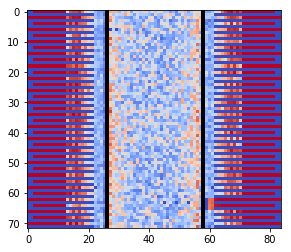

In [21]:
input_images=data_sample[:]
hotregion_image=[]
deadregion_image=[]

for k in input_images:
    a=np.random.randint(input_images.shape[2]-1)
    b=np.random.randint(input_images.shape[1]-1)

    xdim=(a,a+1)
    ydim=(b,b+1)
   
    hotregion_image.append( u.hotregion(k,xdim,ydim))
    deadregion_image.append(u.killregion(k,xdim,ydim))
       
    
hotregion_image=np.array(hotregion_image)
deadregion_image=np.array(deadregion_image)

print "Shape of regular image is: ",input_images.shape
print "Shape of dead image is: " ,deadregion_image.shape
print "Shape of hot image is: " ,hotregion_image.shape

print ''
im=plt.imshow(input_images[1],cmap=cm.coolwarm)
#plt.colorbar()
plt.plot([26,26],[0,71],color='black',lw=4,zorder=10)
plt.plot([58,58],[0,71],color='black',lw=4,zorder=10)
plt.show()



#im=plt.imshow(hotregion_image[1],cmap=cm.coolwarm)
#plt.colorbar()
#plt.show()
#plt.clf()#plt.clf clears the figure and it's axis but leaves the window open. 
         #as opposed to plt.close which closes the window. If you are showing many images at a time without
         #closing the window it is better.

#input_image=np.reshape(input_image,(input_image.shape[0],input_image.shape[1]))


If you want to see the group of images

In [5]:
sample= np.append(data_sample,hotregion_image,axis=0)
sample= np.append(sample,deadregion_image,axis=0)
print sample.shape

(8991, 72, 84)



For CNN

create the corresponding label matrices


In [6]:
X=np.copy(sample)

y=np.zeros((sample.shape[0],1))
k=0
for img in X:
    X[k] = X[k] / np.max(img)
    k=k+1

In [7]:
#this is because I am only going to add the hot and dead region images


y[-2*input_images.shape[0]:]=1
#if you want it as intergers leave this as it is
#if you would like it as a vector then do this
y=to_categorical(y,2)

In [8]:
# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

print "X shape is: ",X.shape
print "y shape is: ",y.shape
# input image dimensions
img_rows, img_cols = X.shape[1],X.shape[2]

X shape is:  (8991, 72, 84)
y shape is:  (8991, 2)


Xtrain.shape (2247, 72, 84)
Xtest.shape (6744, 72, 84)
ytrain.shape (2247, 2)
ytest.shape (6744, 2)
Printing labels and their corresponding images
-------------------
[ 0.  1.]


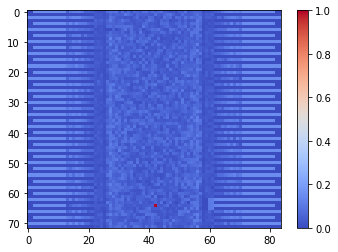

-------------------
[ 0.  1.]


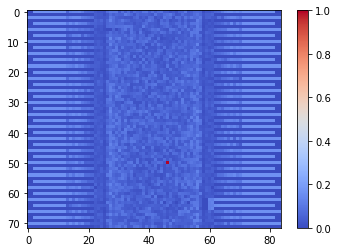

-------------------
[ 0.  1.]


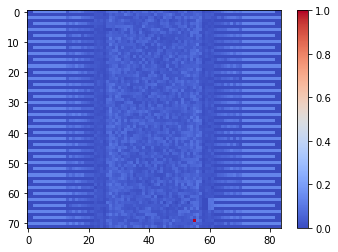

-------------------
[ 1.  0.]


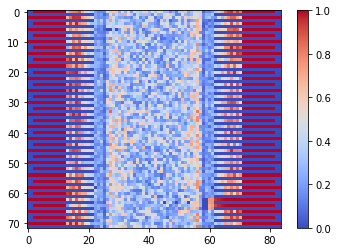

-------------------
[ 0.  1.]


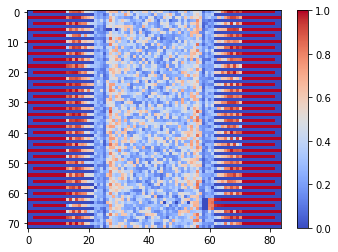

-------------------
[ 0.  1.]


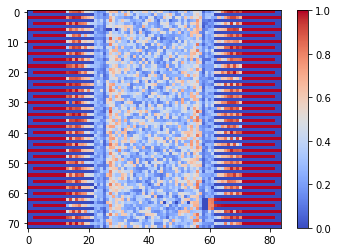

-------------------
[ 1.  0.]


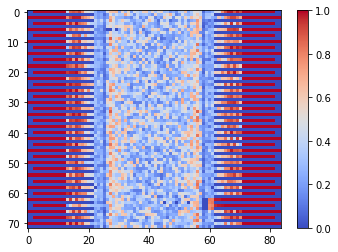

-------------------
[ 0.  1.]


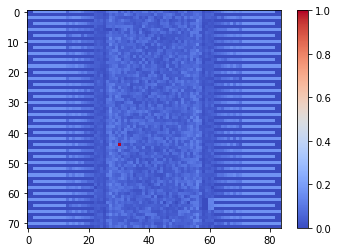

-------------------
[ 0.  1.]


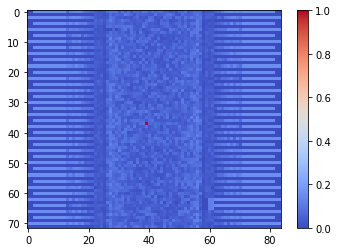

-------------------
[ 1.  0.]


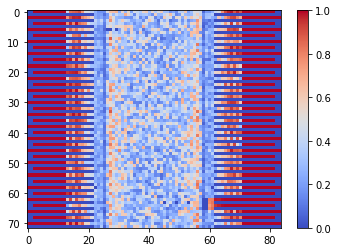

Xtrain.shape after if statement (2247, 72, 84, 1)
Xtest.shape after if statement (6744, 72, 84, 1)
ytrain.shape after if statement (2247, 2)
ytest.shape after if statement (6744, 2)


In [9]:

Xtrain, Xtest ,ytrain, ytest =train_test_split(X,y,test_size=.75,random_state =5 )

print 'Xtrain.shape',Xtrain.shape
print 'Xtest.shape',Xtest.shape
print 'ytrain.shape',ytrain.shape
print 'ytest.shape',ytest.shape
print 'Printing labels and their corresponding images'
    
for k in range(10):
    print'-------------------'
    print ytrain[k]
    im=plt.imshow(Xtrain[k],cmap=cm.coolwarm)
    plt.colorbar()
    plt.show()
    plt.clf()


Xtrain, Xtest,input_shape= u.check_test_and_train_images_format(Xtrain, Xtest, img_rows, img_cols)

print 'Xtrain.shape after if statement',Xtrain.shape
print 'Xtest.shape after if statement',Xtest.shape
print 'ytrain.shape after if statement',ytrain.shape
print 'ytest.shape after if statement',ytest.shape
    


# Creating the model

In [10]:
# this is the dummy model
model = Sequential()

model.add(Conv2D(10, kernel_size=(2, 2), strides=(1, 1),input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(8, kernel_size=(3, 3),strides=(1, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(8,kernel_size=(1,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(8))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(2, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='Nadam',#Adam(lr=1e-3),
              metrics=['accuracy'])
model.summary()
plot_model(model, to_file='Supervised_model.png',)

model.save('emptymodel.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 71, 83, 10)        50        
_________________________________________________________________
batch_normalization_1 (Batch (None, 71, 83, 10)        40        
_________________________________________________________________
activation_1 (Activation)    (None, 71, 83, 10)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 41, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 39, 8)         728       
_________________________________________________________________
batch_normalization_2 (Batch (None, 33, 39, 8)         32        
_________________________________________________________________
activation_2 (Activation)    (None, 33, 39, 8)         0         
__________

In [12]:
#ypred=model.predict(Xtest)
#ypredproba=model.predict_proba(Xtest)
##it's preferable to use .predict_classes because .predict might give probabilities 
##and not the label's in the case of multiclass
#ypredclass=model.predict_classes(Xtest)

#ypredclass=np.reshape(ypredclass,(ypredclass.shape[0],1))
##use argmax(1) to give the position of max value in a categorical variable like ytest
##it's basically a .predict_classes for ytest
#ytestclass= ytest.argmax(1)
#ytestclass=np.reshape(ytestclass,(ytestclass.shape[0],1))

In [13]:
#print ytestclass[40:50],'\n\n\n', ypredclass[40:50]

In [15]:
# from categorial to lable indexing


#yprednotcategorical =ypred.argmax(1)
#print ytestnotcategorical
#print yprednotcategorical
#print metrics.accuracy_score(ytestclass,ypredclass)
#confusion= metrics.confusion_matrix(ytestclass,ypredclass)

#plotlabels=['good','hot','dead']
#plotlabels=['Good','Bad']
#u.plot_confusion_matrix(confusion,plotlabels,title='Confusion Matrix')

In [16]:
for i in range(ypredproba.shape[1]):
    fpr,tpr,thresholds= roc_curve(ytestclass,ypredproba[:,i],pos_label=i)
    roc_auc = auc(fpr, tpr)
    print roc_auc,'For the label #{0}'.format(i)

    plt.plot(fpr,tpr, linestyle='dashed'
             ,label='ROC curve of class {0} (area = %0.3f)'.format(i) % roc_auc,marker='.')#, color='green'markerfacecolor='blue' ,markersize=4,
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--') 
    #plt.xlim([-.1,1.5])

    #plt.ylim([-0.1,1.5])    

    plt.title('ROC curve')

    plt.ylabel('True Positive Rate')

    plt.xlabel('False Positive Rate')

    plt.legend()

    plt.grid(True)
 

NameError: name 'ypredproba' is not defined

In [17]:
checkpointer = ModelCheckpoint(filepath='best_nbmodel_good_hot_dead.hdf5', verbose=2, save_best_only=True)
earlystop= EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto')

In [18]:
history = model.fit(Xtrain,ytrain,epochs=300
                    ,verbose=2
                    ,validation_data=(Xtest,ytest)
                    ,shuffle=True
                    ,callbacks=[checkpointer,earlystop])

Train on 2247 samples, validate on 6744 samples
Epoch 1/300
Epoch 00001: val_loss improved from inf to 0.54346, saving model to best_nbmodel_good_hot_dead.hdf5
 - 120s - loss: 0.5252 - acc: 0.6515 - val_loss: 0.5435 - val_acc: 0.6633
Epoch 2/300
Epoch 00002: val_loss improved from 0.54346 to 0.48850, saving model to best_nbmodel_good_hot_dead.hdf5
 - 119s - loss: 0.4751 - acc: 0.6613 - val_loss: 0.4885 - val_acc: 0.6633
Epoch 3/300
Epoch 00003: val_loss improved from 0.48850 to 0.47339, saving model to best_nbmodel_good_hot_dead.hdf5
 - 119s - loss: 0.4685 - acc: 0.6707 - val_loss: 0.4734 - val_acc: 0.6633
Epoch 4/300
Epoch 00004: val_loss did not improve
 - 111s - loss: 0.4657 - acc: 0.6787 - val_loss: 0.4799 - val_acc: 0.6633
Epoch 5/300
Epoch 00005: val_loss improved from 0.47339 to 0.46298, saving model to best_nbmodel_good_hot_dead.hdf5
 - 110s - loss: 0.4642 - acc: 0.6782 - val_loss: 0.4630 - val_acc: 0.6624
Epoch 6/300
Epoch 00006: val_loss did not improve
 - 112s - loss: 0.4627

Epoch 59/300
Epoch 00059: val_loss did not improve
 - 122s - loss: 0.4300 - acc: 0.7152 - val_loss: 0.4471 - val_acc: 0.7073
Epoch 60/300
Epoch 00060: val_loss improved from 0.43343 to 0.43291, saving model to best_nbmodel_good_hot_dead.hdf5
 - 114s - loss: 0.4306 - acc: 0.7259 - val_loss: 0.4329 - val_acc: 0.7245
Epoch 61/300
Epoch 00061: val_loss did not improve
 - 118s - loss: 0.4318 - acc: 0.7187 - val_loss: 0.4863 - val_acc: 0.6631
Epoch 62/300
Epoch 00062: val_loss improved from 0.43291 to 0.43288, saving model to best_nbmodel_good_hot_dead.hdf5
 - 119s - loss: 0.4266 - acc: 0.7281 - val_loss: 0.4329 - val_acc: 0.7251
Epoch 63/300
Epoch 00063: val_loss did not improve
 - 122s - loss: 0.4239 - acc: 0.7308 - val_loss: 0.4438 - val_acc: 0.6625
Epoch 64/300
Epoch 00064: val_loss did not improve
 - 120s - loss: 0.4238 - acc: 0.7330 - val_loss: 0.4967 - val_acc: 0.6628
Epoch 65/300
Epoch 00065: val_loss did not improve
 - 119s - loss: 0.4299 - acc: 0.7210 - val_loss: 0.7126 - val_acc: 

Epoch 00118: val_loss did not improve
 - 126s - loss: 0.3803 - acc: 0.7944 - val_loss: 0.3697 - val_acc: 0.7714
Epoch 119/300
Epoch 00119: val_loss did not improve
 - 124s - loss: 0.3435 - acc: 0.8158 - val_loss: 0.3585 - val_acc: 0.8231
Epoch 120/300
Epoch 00120: val_loss did not improve
 - 121s - loss: 0.3401 - acc: 0.8158 - val_loss: 0.3676 - val_acc: 0.8075
Epoch 121/300
Epoch 00121: val_loss did not improve
 - 121s - loss: 0.3284 - acc: 0.8296 - val_loss: 1.9515 - val_acc: 0.6633
Epoch 122/300
Epoch 00122: val_loss improved from 0.35196 to 0.34694, saving model to best_nbmodel_good_hot_dead.hdf5
 - 120s - loss: 0.3267 - acc: 0.8349 - val_loss: 0.3469 - val_acc: 0.8385
Epoch 123/300
Epoch 00123: val_loss improved from 0.34694 to 0.32935, saving model to best_nbmodel_good_hot_dead.hdf5
 - 124s - loss: 0.3223 - acc: 0.8278 - val_loss: 0.3293 - val_acc: 0.8437
Epoch 124/300
Epoch 00124: val_loss did not improve
 - 122s - loss: 0.3308 - acc: 0.8251 - val_loss: 0.3333 - val_acc: 0.8452


 - 116s - loss: 0.2725 - acc: 0.8652 - val_loss: 0.2975 - val_acc: 0.8621
Epoch 180/300
Epoch 00180: val_loss did not improve
 - 118s - loss: 0.2713 - acc: 0.8714 - val_loss: 0.3404 - val_acc: 0.8407
Epoch 181/300
Epoch 00181: val_loss did not improve
 - 117s - loss: 0.2698 - acc: 0.8674 - val_loss: 0.8501 - val_acc: 0.6610
Epoch 182/300
Epoch 00182: val_loss did not improve
 - 112s - loss: 0.2630 - acc: 0.8745 - val_loss: 0.3485 - val_acc: 0.7931
Epoch 183/300
Epoch 00183: val_loss did not improve
 - 110s - loss: 0.2689 - acc: 0.8652 - val_loss: 0.3674 - val_acc: 0.7960
Epoch 184/300
Epoch 00184: val_loss did not improve
 - 115s - loss: 0.2692 - acc: 0.8718 - val_loss: 0.3124 - val_acc: 0.8496
Epoch 185/300
Epoch 00185: val_loss did not improve
 - 112s - loss: 0.2669 - acc: 0.8700 - val_loss: 0.3113 - val_acc: 0.8538
Epoch 186/300
Epoch 00186: val_loss did not improve
 - 113s - loss: 0.2710 - acc: 0.8660 - val_loss: 0.4457 - val_acc: 0.7334
Epoch 187/300
Epoch 00187: val_loss did not 

Epoch 244/300
Epoch 00244: val_loss did not improve
 - 109s - loss: 0.2581 - acc: 0.8745 - val_loss: 0.3078 - val_acc: 0.8538
Epoch 245/300
Epoch 00245: val_loss did not improve
 - 106s - loss: 0.2505 - acc: 0.8745 - val_loss: 0.3097 - val_acc: 0.8504
Epoch 246/300
Epoch 00246: val_loss did not improve
 - 106s - loss: 0.2468 - acc: 0.8807 - val_loss: 0.2977 - val_acc: 0.8646
Epoch 247/300
Epoch 00247: val_loss did not improve
 - 108s - loss: 0.2469 - acc: 0.8807 - val_loss: 0.9909 - val_acc: 0.6765
Epoch 248/300
Epoch 00248: val_loss did not improve
 - 107s - loss: 0.2423 - acc: 0.8741 - val_loss: 5.2068 - val_acc: 0.6633
Epoch 00248: early stopping


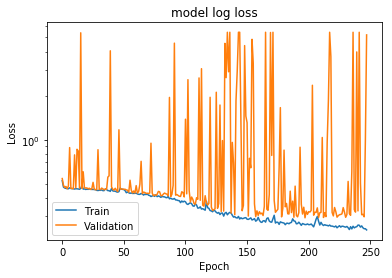

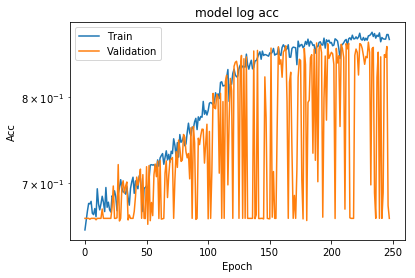

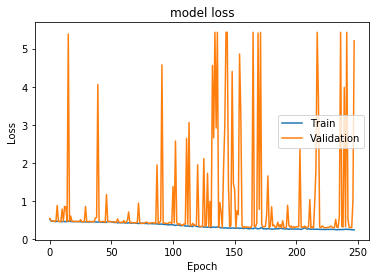

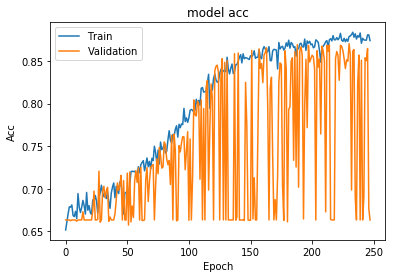

In [19]:

u.plot_loss(history, "model log loss","log")
u.plot_acc(history, "model log acc","log")

u.plot_loss(history, "model loss","linear")
u.plot_acc(history, "model acc","linear")


# Loading and Evaluation of a trained model

In [20]:
best_model= load_model('best_nbmodel_good_hot_dead.hdf5',compile=False)

In [21]:
ypred=best_model.predict(Xtest)
ypredproba=best_model.predict_proba(Xtest)
#it's preferable to use .predict_classes because .predict might give probabilities 
#and not the label's in the case of multiclass
ypredclass=best_model.predict_classes(Xtest)

ypredclass=np.reshape(ypredclass,(ypredclass.shape[0],1))
#use argmax(1) to give the position of max value in a categorical variable like ytest
#it's basically a .predict_classes for ytest
ytestclass= ytest.argmax(1)
ytestclass=np.reshape(ytestclass,(ytestclass.shape[0],1))

In [22]:
np.all(ypredproba==ypred)
#this confirms my suspicions

True

Confusion matrix, without normalization
[[2237   34]
 [ 854 3619]]
accuracy score:  0.868327402135


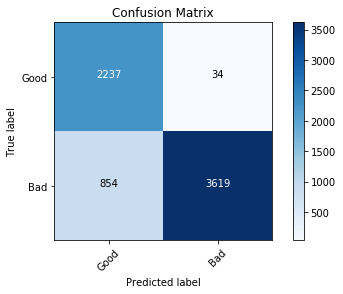

In [28]:
# from categorial to lable indexing


#yprednotcategorical =ypred.argmax(1)
#print ytestnotcategorical
#print yprednotcategorical
confusion= metrics.confusion_matrix(ytestclass,ypredclass)

plotlabels=['Good','Bad']
u.plot_confusion_matrix(confusion,plotlabels,title='Confusion Matrix')
print 'accuracy score: ',metrics.accuracy_score(ytestclass,ypredclass)


0.89942906128 For the label #0
0.89942906128 For the label #1


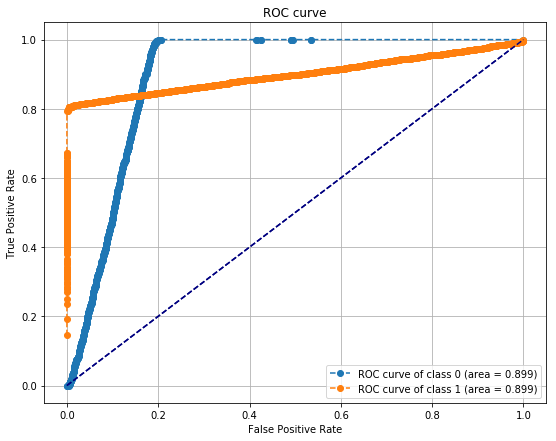

In [24]:
plt.figure(figsize=(9,7))
for i in range(ypredproba.shape[1]):
    fpr,tpr,thresholds= roc_curve(ytestclass,ypredproba[:,i],pos_label=i)
    roc_auc = auc(fpr, tpr)
    print roc_auc,'For the label #{0}'.format(i)

    plt.plot(fpr,tpr, linestyle='dashed'
             ,label='ROC curve of class {0} (area = {1:0.3f})' .format(i,roc_auc) ,marker='o')#% roc_auc, color='green'markerfacecolor='blue' ,markersize=4,
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--') 
    #plt.xlim([-.1,1.5])

    #plt.ylim([-0.1,1.5])    

    plt.title('ROC curve')

    plt.ylabel('True Positive Rate')

    plt.xlabel('False Positive Rate')

    plt.legend()

    plt.grid(True)
 

# Loading and using real bad data

(257, 72, 84)



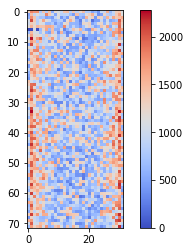

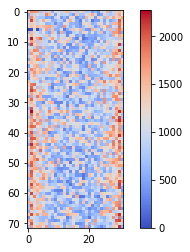

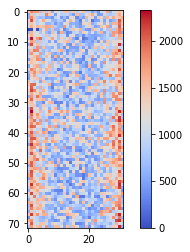

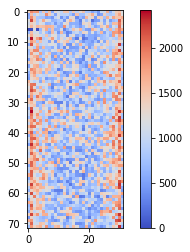

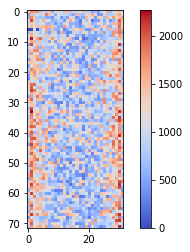

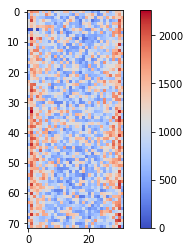

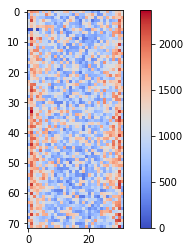

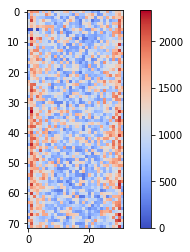

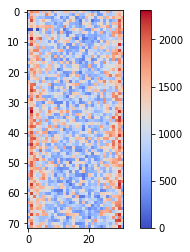

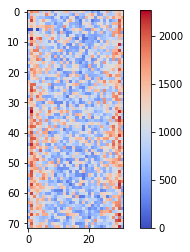

In [25]:
data_folder = '../../data'
file_name = 'HCAL_digi+rechit_occ_run315488_corrupted.hdf5'
group = 'DigiTask_Occupancy_depth_depth1'

input_file=h5py.File(data_folder+"/"+file_name,'r+')

data_sample= np.array(input_file[group])




print data_sample.shape
bad_data_sample=data_sample[:,:,26:58]

for k in bad_data_sample[:10]:
    
    print ''
    
    im=plt.imshow(k,cmap=cm.coolwarm)
    plt.colorbar()
    plt.show()
    plt.clf()

In [26]:
BadX=np.copy(bad_data_sample)
print BadX.shape
Bady=np.zeros((bad_data_sample.shape[0],1))

(257, 72, 32)


In [27]:
if K.image_data_format() == 'channels_first':
        BadX = BadX.reshape(BadX.shape[0], 1, img_rows, img_cols)
else:
        BadX = BadX.reshape(BadX.shape[0], img_rows, img_cols, 1)

ValueError: cannot reshape array of size 592128 into shape (257,72,84,1)

In [ ]:
ybadpredclass=best_model.predict_classes(BadX)
print ybadpredclass.shape
ybadpredclass=ybadpredclass.reshape(ybadpredclass.shape[0],1)

In [ ]:
print ybadpredclass[:5].shape

In [ ]:
print ybadpredclass

In [ ]:
bconfm= metrics.confusion_matrix(Bady,ybadpredclass)

plotlabels=['good','bad']
u.plot_confusion_matrix(bconfm,plotlabels,title='Confusion Matrix')
print 'accuracy score: ',metrics.accuracy_score(Bady,ybadpredclass)
